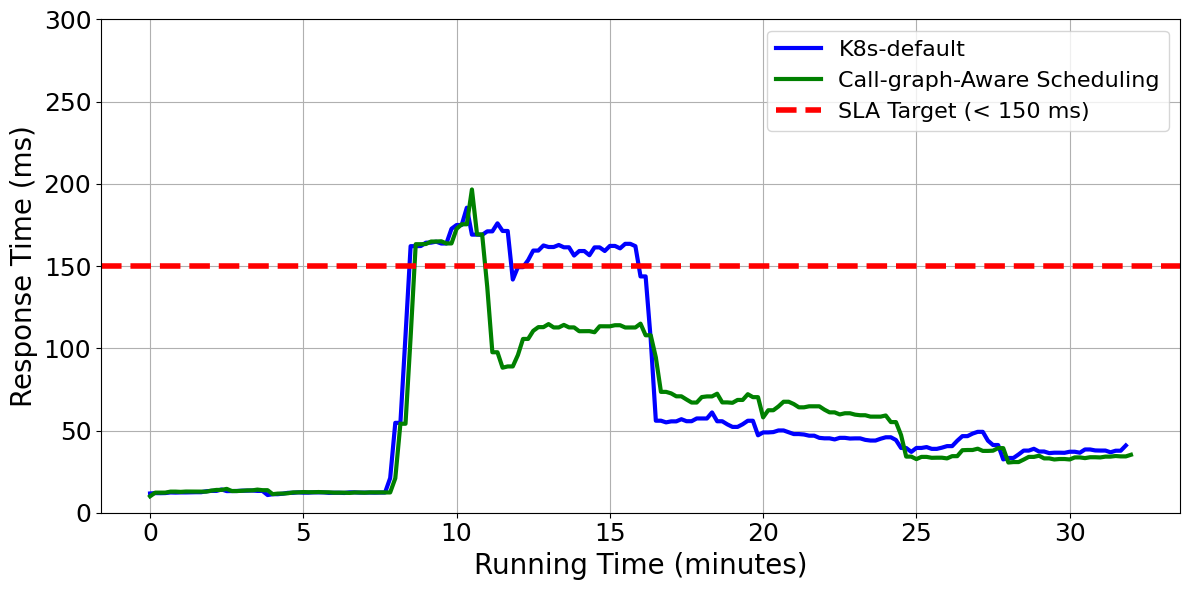

In [ ]:
#  Udpate the previous figure's Y limit from 225 to 300.


import pandas as pd
import matplotlib.pyplot as plt
import ast

QoS_target = 150
colors      = ['blue', 'green']
labels      = ['K8s-default', 'Call-graph-Aware Scheduling']
files       = ['data/k8s_2025_Mar_18_1156_avg_latency.csv',
               'data/callGraph_2025_Mar_18_1156_avg_latency.csv']

def load_trace(path):
    # 1. read & parse
    df = pd.read_csv(path, parse_dates=['timestamp'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # 2. drop the “response_code != 200” rows (they carry the 0-ms values)
    df['response_code'] = df['metric'].apply(
        lambda s: ast.literal_eval(s)['response_code'])
    df = df[df['response_code'] == '200']

    # 3. if several 200-rows share a timestamp, average them
    df = df.groupby('timestamp', as_index=False)['value'].mean()

    # 4. build a time axis that starts at 0 min for each run
    df['elapsed_min'] = (df['timestamp'] - df['timestamp'].min()
                         ).dt.total_seconds() / 60
    return df

traces = [load_trace(f) for f in files]

# -------- plot --------
plt.figure(figsize=(12, 6))
for trace, c, lbl in zip(traces, colors, labels):
    plt.plot(trace['elapsed_min'], trace['value'],
             color=c, linewidth=3, label=lbl)

plt.axhline(QoS_target, color='red', linestyle='--', linewidth=4,
            label=f'SLA Target (< {QoS_target} ms)')

plt.ylim(0, QoS_target * 2)
plt.xlabel('Running Time (minutes)', fontsize=20)
plt.ylabel('Response Time (ms)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()
